In [2]:
import numpy as np
np.random.seed(42)

import random
random.seed(42)

In [28]:
#Load data in and create ratings matrix
#Do we remove zero columns?

import pandas
import numpy as np

ratings_df = pandas.read_csv('ratings.csv')

userIDs = ratings_df['userId'].values
movies = ratings_df['movieId'].values
ratings = ratings_df['rating'].values

#Make ratings matrix
max_movie = max(movies)
max_userID = max(userIDs)

ratings_mat = np.zeros((max_userID, max_movie))

for i in range(len(userIDs)):
    sel_userID = userIDs[i]
    sel_movie = movies[i]
    sel_rating = ratings[i]
    #Make user 1 be index 0, etc.
    ratings_mat[sel_userID - 1, sel_movie - 1] = sel_rating
    
#Remove zero columns
idx = np.argwhere(np.all(ratings_mat[..., :] == 0, axis=0))
ratings_mat = np.delete(ratings_mat, idx, axis=1)

#Remove zero rows (should be none, but just in case)
idx = np.argwhere(np.all(ratings_mat[..., :] == 0, axis=1))
ratings_mat = np.delete(ratings_mat, idx, axis=0)

sparsity = np.count_nonzero(ratings_mat)/(np.prod(ratings_mat.shape))




#Compute again using dictionary of movies/userIDs
movies_dict = {}
user_dict = {}
for i in range(len(userIDs)):
    
    #Use movieID as key
    if (movies[i] not in movies_dict.keys()):
        movies_dict[movies[i]] = [(userIDs[i], ratings[i])]
    else:
        movies_dict[movies[i]].append((userIDs[i], ratings[i]))
        
    #Use userID as key
    if (userIDs[i] not in user_dict.keys()):
        user_dict[userIDs[i]] = [(movies[i], ratings[i])]
    else:
        user_dict[userIDs[i]].append((movies[i], ratings[i]))

num_ratings = 0
for movieID in movies_dict.keys():
    for item in movies_dict[movieID]:
        num_ratings += 1

sparsity_dict = num_ratings/(len(movies_dict.keys()) * len(user_dict.keys()))

print("Sparsity is: {}".format(sparsity))
print("Sparsity (dict) is: {}".format(sparsity_dict))

Sparsity is: 0.016999683055613623
Sparsity (dict) is: 0.016999683055613623


In [4]:
#Q2

import matplotlib.pyplot as plt

#Bars are centered around the ratings (0.5, 1, 1.5, etc.)
plt.hist(ratings, bins=[-0.25, 0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25])
plt.xlabel("Rating")
plt.title("Histogram of Movie Ratings")
plt.ylabel("Number of Occurences")
plt.show()

#Looks normally distributed, mean around 3.5-4. Most reviewed movies were enjoyed by the viewer
#Nobody gave a review of 0/5

<Figure size 640x480 with 1 Axes>

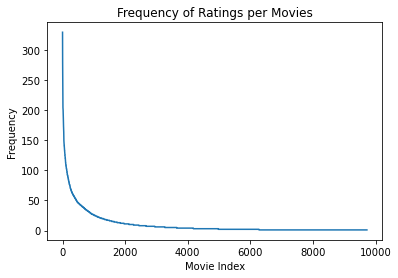

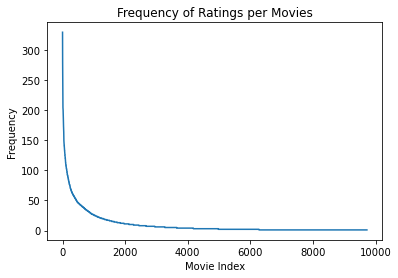

In [29]:
#Q3

freqs = np.count_nonzero(ratings_mat, axis=0)

freqs = np.sort(freqs)
movie_ind = np.flip(np.arange(freqs.shape[0]))
plt.plot(movie_ind,freqs)
plt.xlabel("Movie Index")
plt.ylabel("Frequency")
plt.title("Frequency of Ratings per Movies")
plt.show()


freqs = []
for movie in movies_dict.keys():
    freqs.append(len(movies_dict[movie]))

freqs = np.sort(np.asarray(freqs))
movie_ind = np.flip(np.arange(freqs.shape[0]))
plt.plot(movie_ind,freqs)
plt.xlabel("Movie Index")
plt.ylabel("Frequency")
plt.title("Frequency of Ratings per Movies")
plt.show()    

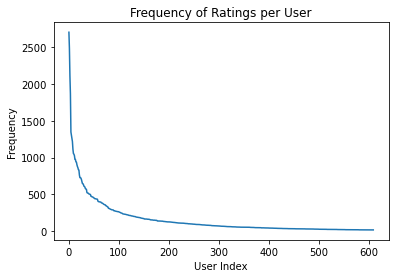

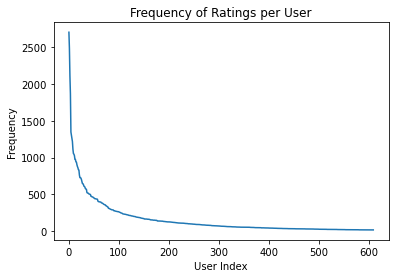

In [30]:
#Q4

freqs = np.count_nonzero(ratings_mat, axis=1)

freqs = np.sort(freqs)
movie_ind = np.flip(np.arange(freqs.shape[0]))
plt.plot(movie_ind,freqs)
plt.xlabel("User Index")
plt.ylabel("Frequency")
plt.title("Frequency of Ratings per User")
plt.show()

freqs = []
for movie in user_dict.keys():
    freqs.append(len(user_dict[movie]))

freqs = np.sort(np.asarray(freqs))
movie_ind = np.flip(np.arange(freqs.shape[0]))
plt.plot(movie_ind,freqs)
plt.xlabel("User Index")
plt.ylabel("Frequency")
plt.title("Frequency of Ratings per User")
plt.show()

Q5

Recommendations will be heavily weighted towards a few hundred movies, since those are the most reviewed ones. Most movies have less than 25 reviews, so our matrix will be sparse.

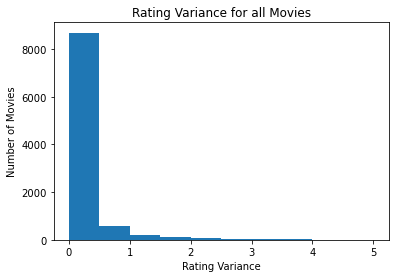

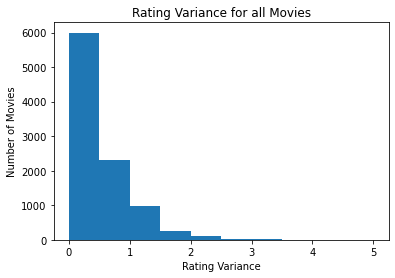

In [31]:
#Q6
#Variances are strangely low

#Variances are low for most movies (0-0.5). This suggests that most users seem to agree on which movies are good/bad
variances = np.var(ratings_mat, axis=0)

hist_bins = np.arange(0, 5.5, 0.5)
plt.hist(variances, bins=hist_bins)
plt.xlabel("Rating Variance")
plt.title("Rating Variance for all Movies")
plt.ylabel("Number of Movies")
plt.show()

variances = []
for movie in movies_dict.keys():
    temp_vars = []
    for item in movies_dict[movie]:
        temp_vars.append(item[1])
    variances.append(np.var(np.asarray(temp_vars)))
    
plt.hist(variances, bins=hist_bins)
plt.xlabel("Rating Variance")
plt.title("Rating Variance for all Movies")
plt.ylabel("Number of Movies")
plt.show()        

Q7

$\mu_u = \frac{\sum_{k \in{I_u}}r_{uk}}{length(I_u)}$

Q8

$I_u \cap I_v$ represents the set of indices for the movies rated by both users u and v. This can be equal to $\emptyset$, meaning that they haven't seen any of the same movies. Given that our rating matrix is very sparse, this is likely to be the case if we were to randomly select any two users.

Q9

This mean-centering process helps reduce the influence of outliers, and reduce bias in our predictions. This would remove the effect of users that only give high/low ratings of movies, since the low variance of their rankings suggests that their opinions on movies are biased and may not be suitable for movie recommendations. 

In [8]:
#Q10

from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.similarities import pearson
from surprise.model_selection.validation import cross_validate
from surprise.dataset import Dataset
from surprise.reader import Reader

ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)

sim_options = {'name': 'pearson',
               'user_based': True
               }

#Do we need to add skip_lines=1 to remove the headers?
reader_df_pd = Reader(rating_scale=(0.5, 5))
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

rmse_vals = []
mae_vals = []
k_vals = np.arange(2, 102, 2)

#Unnecessarilly large number of k values - could stop at 50 and get the same result
for k in k_vals:
    if (k % 10 == 0):
        print("Working with k = {}".format(k))
    curr_knn = KNNWithMeans(k, sim_options=sim_options, verbose=False)
    cv_result = cross_validate(curr_knn, ratings_df_sup, cv=10, measures=['rmse', 'mae'])
    rmse_vals.append(np.average(cv_result['test_rmse']))
    mae_vals.append(np.average(cv_result['test_mae']))

plt.plot(k_vals, rmse_vals)
plt.title("KNNWithMeans Average RMSE Errors for Various k")
plt.xlabel("k")
plt.xlabel("Average RMSE")
plt.show()

plt.figure;
plt.plot(k_vals, mae_vals)
plt.title("KNNWithMeans Average MAE Errors for Various k")
plt.xlabel("k")
plt.xlabel("Average MAE")
plt.show()

Working with k = 10
Working with k = 20


KeyboardInterrupt: 

In [71]:
#Q11

#We can see that our minimum k for both is around 24. The steady state averages for both are as follows:

rmse_min_k = 24
mae_min_k = 24
print("Steady state average RMSE error = {}".format(np.average(rmse_vals[rmse_min_k//2 - 1:])))
print("Steady state average MAE error = {}".format(np.average(mae_vals[mae_min_k//2 - 1:])))
      

Steady state average RMSE error = 0.8902307939715115
Steady state average MAE error = 0.6778219746650128


In [22]:
#Q12-14

from surprise import accuracy
from surprise.model_selection import KFold


def trim_pop(arr):
    
    elem_dict = {}
    ret_arr = []
    for elem in arr:
        
        #Use movieID as key
        if (elem[1] not in elem_dict.keys()):
            elem_dict[elem[1]] = [elem]
        else:
            elem_dict[elem[1]].append(elem)
    
    for movID in elem_dict.keys():
        if (len(elem_dict[movID]) > 2):
            for elem in elem_dict[movID]:
                ret_arr.append(elem)
    return ret_arr

def trim_unpop(arr):
    elem_dict = {}
    ret_arr = []
    for elem in arr:
        
        #Use movieID as key
        if (elem[1] not in elem_dict.keys()):
            elem_dict[elem[1]] = [elem]
        else:
            elem_dict[elem[1]].append(elem)
    
    for movID in elem_dict.keys():
        if (len(elem_dict[movID]) <= 2):
            for elem in elem_dict[movID]:
                ret_arr.append(elem)
    return ret_arr

def trim_var(arr):
    elem_dict = {}
    ret_arr = []
    for elem in arr:
        
        #Use movieID as key
        if (elem[1] not in elem_dict.keys()):
            elem_dict[elem[1]] = [elem]
        else:
            elem_dict[elem[1]].append(elem)
    
    for movID in elem_dict.keys():
        if (len(elem_dict[movID]) >= 5):
            rating_arr = []
            elem_arr = []
            for elem in elem_dict[movID]:
                rating_arr.append(elem[2])
                elem_arr.append(elem)
            if (np.var(np.asarray(rating_arr)) >= 2):
                ret_arr += elem_arr
                
    return ret_arr


num_splits = 10
kf = KFold(n_splits=num_splits)

k_vals = np.arange(2, 102, 2)
rmse_vals_12 = []
rmse_vals_13 = []
rmse_vals_14 = []

for k in k_vals:
    
    if (k % 10 == 0):
        print("Working with k = {}".format(k))
        
    algo = KNNWithMeans(k, sim_options=sim_options, verbose=False)
    temp_rmse_12 = 0
    temp_rmse_13 = 0
    temp_rmse_14 = 0
    
    for trainset, testset in kf.split(ratings_df_sup):

        #fit training set
        algo.fit(trainset)
        
        
        #Q12
        predictions = algo.test(trim_pop(testset))
        temp_rmse_12 += accuracy.rmse(predictions, verbose=False)

        #Q13
        predictions = algo.test(trim_unpop(testset))
        temp_rmse_13 += accuracy.rmse(predictions, verbose=False)
        
        #Q14
        predictions = algo.test(trim_var(testset))
        temp_rmse_14 += accuracy.rmse(predictions, verbose=False)
    
    rmse_vals_12.append(temp_rmse_12/num_splits)
    rmse_vals_13.append(temp_rmse_13/num_splits)
    rmse_vals_14.append(temp_rmse_14/num_splits)


plt.plot(k_vals, rmse_vals_12)
plt.title("KNNWithMeans Average RMSE Errors for Various k (Popular Movie Trimming)")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

plt.plot(k_vals, rmse_vals_13)
plt.title("KNNWithMeans Average RMSE Errors for Various k (Unpopular Movie Trimming)")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

plt.figure;
plt.plot(k_vals, rmse_vals_14)
plt.title("KNNWithMeans Average MAE Errors for Various k (High Variance Movie Trimming)")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

KeyboardInterrupt: 

In [73]:
#No steady-state minimum, just minimum 

print("Minimum RMSE error for Popular Trimming = {}".format(min(rmse_vals_12)))
print("Minimum RMSE error for Unpopular Trimming = {}".format(min(rmse_vals_13)))
print("Minimum RMSE error for High Variance Trimming = {}".format(min(rmse_vals_14)))


Steady state average RMSE error for Popular Trimming = 0.8571789006611374
Steady state average RMSE error for Unpopular Trimming = 0.9578362857675634
Steady state average RMSE error for High Variance Trimming = 1.410082892304278


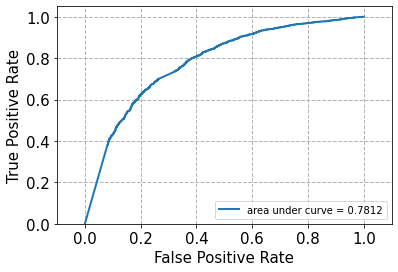

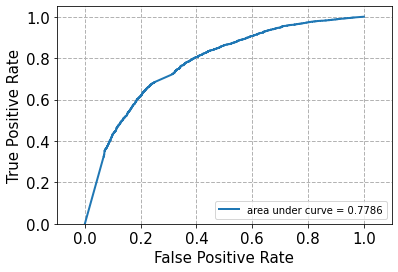

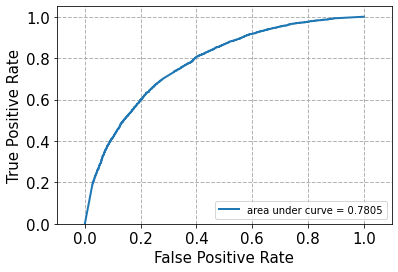

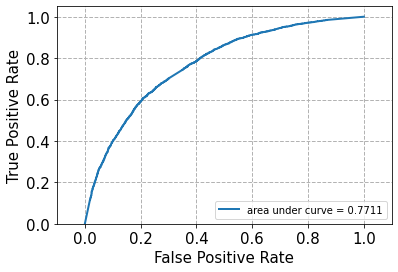

In [12]:
#Q15
from surprise.model_selection import train_test_split
from sklearn import metrics

def plot_roc(fpr, tpr):
    #helper function taken from discussion notebook
    fig, ax = plt.subplots()

    roc_auc = metrics.auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

threshold_values = [2.5,3,3.5,4]

for i in threshold_values:
    #Thresholding before AND after KNN?
    ratings_df_pd = pandas.read_csv('ratings.csv')
    ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)
    ratings_df_sup['rating']=ratings_df_sup['rating'].mask(ratings_df_sup['rating'] < i,0) #question: < or <= ?
    ratings_df_sup['rating']=ratings_df_sup['rating'].mask(ratings_df_sup['rating'] >= i,1) #ditto

    
    reader_th = Reader(rating_scale=(0,1))
    ratings_th = Dataset.load_from_df(ratings_df_sup, reader_th)

    trainset, testset = train_test_split(ratings_th, test_size=.1)
    
    curr_knn = KNNWithMeans(k=24, sim_options=sim_options, verbose=False)
    curr_knn.fit(trainset)
    predictions = curr_knn.test(testset)
    
    preds_list = [elem[3] for elem in predictions]
    #need 1D list to match preds_list
    true_list = []
    for j in range(len(testset)):
        true_list.append(testset[j][2])

     
    fpr, tpr, thresholds = metrics.roc_curve(true_list, preds_list)
    plot_roc(fpr,tpr)

Q16

Just equation 5 but with the V removed from the minimization problem. This is already a least squares problem

Working with k = 10
Working with k = 20
Working with k = 30
Working with k = 40
Working with k = 50


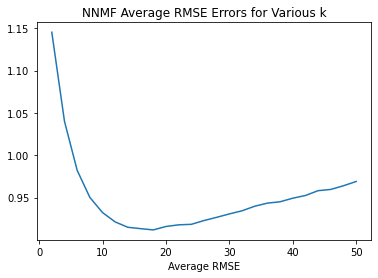

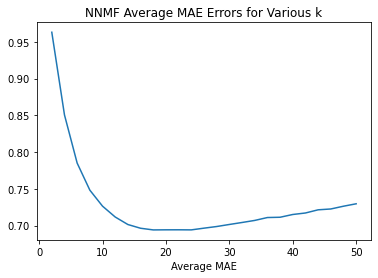

In [15]:
#Q17

from surprise.prediction_algorithms.matrix_factorization import NMF

rmse_vals = []
mae_vals = []
k_vals = np.arange(2, 52, 2)

ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)
reader_df_pd = Reader(rating_scale=(0.5, 5))
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

for k in k_vals:
    if (k % 4 == 0):
        print("Working with k = {}".format(k))
    curr_nnmf = NMF(n_factors = k)
    cv_result = cross_validate(curr_nnmf, ratings_df_sup, cv=10, measures=['rmse', 'mae'])
    rmse_vals.append(np.average(cv_result['test_rmse']))
    mae_vals.append(np.average(cv_result['test_mae']))

    

plt.plot(k_vals, rmse_vals)
plt.title("NNMF Average RMSE Errors for Various k")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

plt.figure;
plt.plot(k_vals, mae_vals)
plt.title("NNMF Average MAE Errors for Various k")
plt.xlabel("k")
plt.ylabel("Average MAE")
plt.show()
    

In [35]:
#Q18

#From README, there are 19 genre (including "(no genres listed)" being a genre). for RMSE and MAE k=18 ~= 19.
print("k for Mimimum Average RMSE error = {}".format((np.argmin(rmse_vals) + 1)*2))
print("k for Minimum Average MAE error = {}".format((np.argmin(mae_vals) + 1)*2))     

k for Mimimum Average RMSE error = 18
k for Minimum Average MAE error = 18


Working with k = 4
Working with k = 8
Working with k = 12
Working with k = 16
Working with k = 20
Working with k = 24
Working with k = 28
Working with k = 32
Working with k = 36
Working with k = 40
Working with k = 44
Working with k = 48


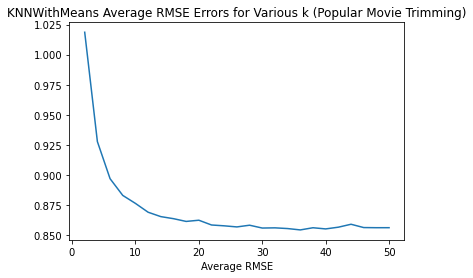

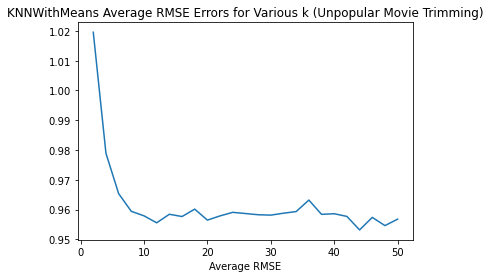

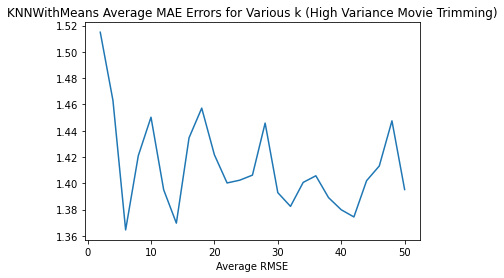

In [24]:
#Q19-21

from surprise import accuracy
from surprise.model_selection import KFold

num_splits = 10
kf = KFold(n_splits=num_splits)

k_vals = np.arange(2, 52, 2)
rmse_vals_19 = []
rmse_vals_20 = []
rmse_vals_21 = []

ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)
reader_df_pd = Reader(rating_scale=(0.5, 5))
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

for k in k_vals:
    
    if (k % 4 == 0):
        print("Working with k = {}".format(k))
        
    algo = KNNWithMeans(k, sim_options=sim_options, verbose=False)
    temp_rmse_19 = 0
    temp_rmse_20 = 0
    temp_rmse_21 = 0
    
    for trainset, testset in kf.split(ratings_df_sup):

        #fit training set
        algo.fit(trainset)
        
        
        #Q19
        predictions = algo.test(trim_pop(testset))
        temp_rmse_19 += accuracy.rmse(predictions, verbose=False)

        #Q20
        predictions = algo.test(trim_unpop(testset))
        temp_rmse_20 += accuracy.rmse(predictions, verbose=False)
        
        #Q21
        predictions = algo.test(trim_var(testset))
        temp_rmse_21 += accuracy.rmse(predictions, verbose=False)
    
    rmse_vals_19.append(temp_rmse_19/num_splits)
    rmse_vals_20.append(temp_rmse_20/num_splits)
    rmse_vals_21.append(temp_rmse_21/num_splits)


plt.plot(k_vals, rmse_vals_19)
plt.title("KNNWithMeans Average RMSE Errors for Various k (Popular Movie Trimming)")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

plt.plot(k_vals, rmse_vals_20)
plt.title("KNNWithMeans Average RMSE Errors for Various k (Unpopular Movie Trimming)")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

plt.figure;
plt.plot(k_vals, rmse_vals_21)
plt.title("KNNWithMeans Average MAE Errors for Various k (High Variance Movie Trimming)")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

In [25]:
#Q22

print("Minimum RMSE error for Popular Trimming = {}".format(min(rmse_vals_19)))
print("Minimum RMSE error for Unpopular Trimming = {}".format(min(rmse_vals_20)))
print("Minimum RMSE error for High Variance Trimming = {}".format(min(rmse_vals_21)))


Minimum RMSE error for Popular Trimming = 0.8543232956567911
Minimum RMSE error for Unpopular Trimming = 0.9531958996521561
Minimum RMSE error for High Variance Trimming = 1.364466477539645
